In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import plotly.express as px

import scipy.stats as stats
from scipy.stats import pearsonr
from sklearn.linear_model import LinearRegression
from statsmodels.tsa.arima.model import ARIMA

In [8]:
df_holidays = pd.read_csv('holidays_events.csv', header = 0)
df_oil = pd.read_csv('oil.csv', header = 0)
df_stores = pd.read_csv('stores.csv', header = 0)
df_trans = pd.read_csv('transactions.csv', header = 0)
df_train = pd.read_csv('train.csv', header = 0)
df_test = pd.read_csv('test.csv', header = 0)

# Part 1. Transactions

# Which day of the week most of the transactions happened (what is the daily seasonality in transactions)?

In [9]:
df_trans_copy = df_trans.copy()

In [10]:
df_trans_copy["date"] = pd.to_datetime(df_trans_copy.date)

In [11]:
df_trans_copy["year"] = df_trans_copy.date.dt.year
df_trans_copy["dayofweek"] = df_trans_copy.date.dt.dayofweek
df_trans_copy = df_trans_copy.groupby(["year", "dayofweek"]).transactions.sum().reset_index()
df_trans_copy.head()

,year,dayofweek,transactions
0,2013,0,4072431
1,2013,1,3950674
2,2013,2,3859367
3,2013,3,3793580
4,2013,4,3998777


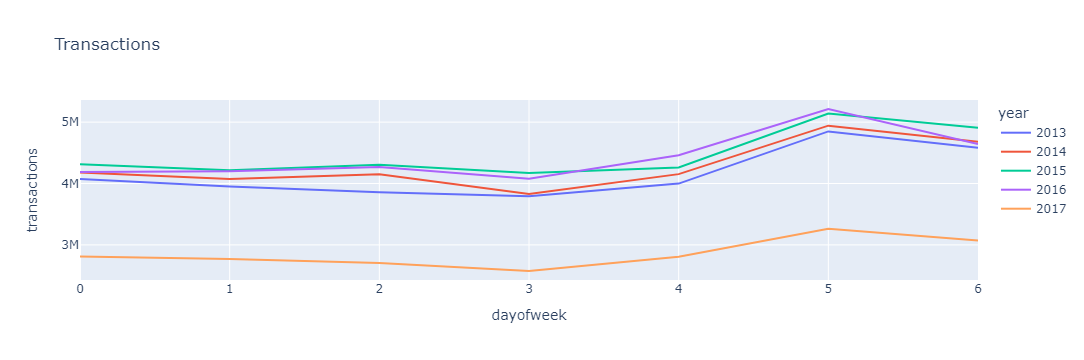

In [12]:
px.line(df_trans_copy, x="dayofweek", y="transactions" , color = "year", title = "Transactions")

In [13]:
# Create a new column to label weekends (1) and weekdays (0)
df_trans_copy['weekend'] = df_trans_copy['dayofweek'].isin([5, 6]).astype(int)

# Split the dataframe into two groups: weekends and weekdays
weekend_transactions = df_trans_copy[df_trans_copy['weekend'] == 1]['transactions']
weekday_transactions = df_trans_copy[df_trans_copy['weekend'] == 0]['transactions']

# Perform a t-test to compare the mean transactions between weekends and weekdays
t_stat, p_value = stats.ttest_ind(weekend_transactions, weekday_transactions)

# Define significance level
alpha = 0.05

# Print the results
if p_value < alpha:
    print("Reject the null hypothesis. Transactions are significantly higher on weekends.")
else:
    print("Fail to reject the null hypothesis. There's no significant difference in transactions between weekends and weekdays.")

Reject the null hypothesis. Transactions are significantly higher on weekends.


# Which state has the higest transcations?

In [14]:
merged_df = pd.merge(df_stores, df_trans, on='store_nbr')
merged_df.head()

,store_nbr,city,state,type,cluster,date,transactions
0,1,Quito,Pichincha,D,13,2013-01-02,2111
1,1,Quito,Pichincha,D,13,2013-01-03,1833
2,1,Quito,Pichincha,D,13,2013-01-04,1863
3,1,Quito,Pichincha,D,13,2013-01-05,1509
4,1,Quito,Pichincha,D,13,2013-01-06,520


In [15]:
# Group by state and sum transactions
transactions_by_state = merged_df.groupby('state')['transactions'].sum().reset_index()
transactions_by_state.head()

,state,transactions
0,Azuay,5673847
1,Bolivar,2107489
2,Chimborazo,2287850
3,Cotopaxi,3531356
4,El Oro,3945341


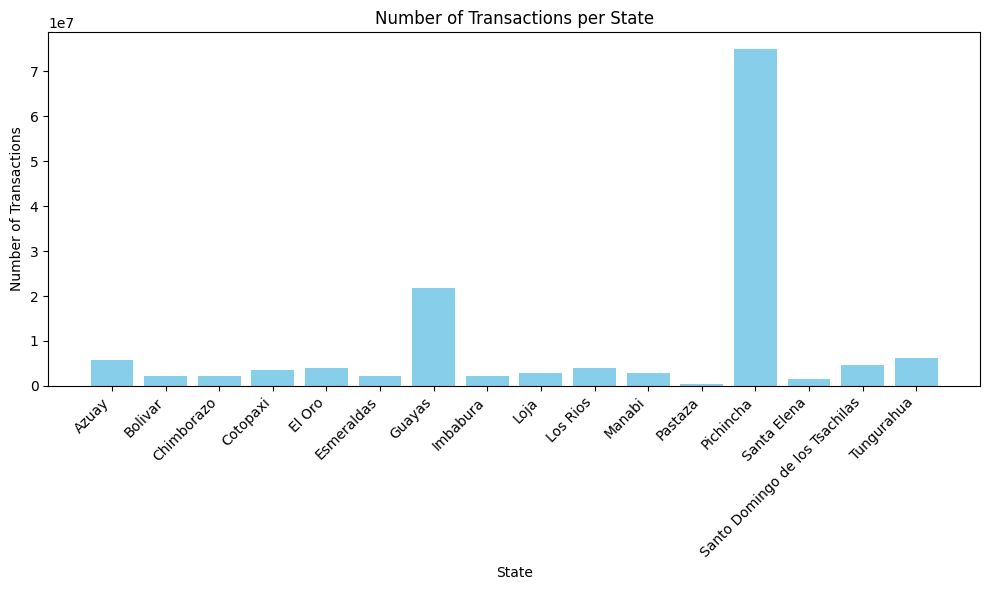

In [16]:
# Plotting the bar chart
plt.figure(figsize=(10, 6))
plt.bar(transactions_by_state['state'], transactions_by_state['transactions'], color='skyblue')

# Adding labels and title
plt.xlabel('State')
plt.ylabel('Number of Transactions')
plt.title('Number of Transactions per State')

# Rotating x-axis labels for better readability
plt.xticks(rotation=45, ha='right')

# Show plot
plt.tight_layout()
plt.show()

# Top 10 stores with highest transactions

In [17]:
# Merge the two DataFrames on the 'store_nbr' column
merged_df = pd.merge(df_stores, df_trans, on='store_nbr')

# Calculate average transactions for each store
average_transactions_per_store = merged_df.groupby('store_nbr')['transactions'].mean().reset_index()

# Rename columns for clarity
average_transactions_per_store.columns = ['store_nbr', 'average_transactions']

# Display the table
print(average_transactions_per_store.head())


   store_nbr  average_transactions
0          1           1523.844272
1          2           1920.036374
2          3           3201.879475
3          4           1502.987470
4          5           1400.045915


In [18]:
# Sort values by 'average_transactions' column in ascending order
sorted_df = average_transactions_per_store.sort_values(by='average_transactions', ascending = False)

# Merge with the original DataFrame to retain 'city' and 'state' columns
sorted_df = pd.merge(sorted_df, df_stores[['store_nbr', 'city', 'state']], on='store_nbr')
# Display the sorted DataFrame
print(sorted_df.head(10))

   store_nbr  average_transactions     city       state
0         44           4336.966607    Quito   Pichincha
1         47           3897.322600    Quito   Pichincha
2         45           3697.742993    Quito   Pichincha
3         46           3571.921884    Quito   Pichincha
4          3           3201.879475    Quito   Pichincha
5         48           3045.787120    Quito   Pichincha
6          8           2767.285800    Quito   Pichincha
7         49           2727.550984    Quito   Pichincha
8         50           2614.456768   Ambato  Tungurahua
9         11           2370.219570  Cayambe   Pichincha


# Which store provides most promotions and is there correlation between transactions and promotions?

In [19]:
# Group by 'store_nbr' and sum 'onpromotion' column
onpromotion_sum_by_store = df_train.groupby('store_nbr')['onpromotion'].sum().reset_index()

# Rename the column for clarity
onpromotion_sum_by_store.columns = ['store_nbr', 'onpromotion_sum']

# Merge with the sorted_df DataFrame
sorted_df = pd.merge(sorted_df, onpromotion_sum_by_store, on='store_nbr', how='left')

In [20]:
sorted_df.head()

,store_nbr,average_transactions,city,state,onpromotion_sum
0,44,4336.966607,Quito,Pichincha,192449
1,47,3897.322600,Quito,Pichincha,192725
2,45,3697.742993,Quito,Pichincha,191503
3,46,3571.921884,Quito,Pichincha,190697
4,3,3201.879475,Quito,Pichincha,177075


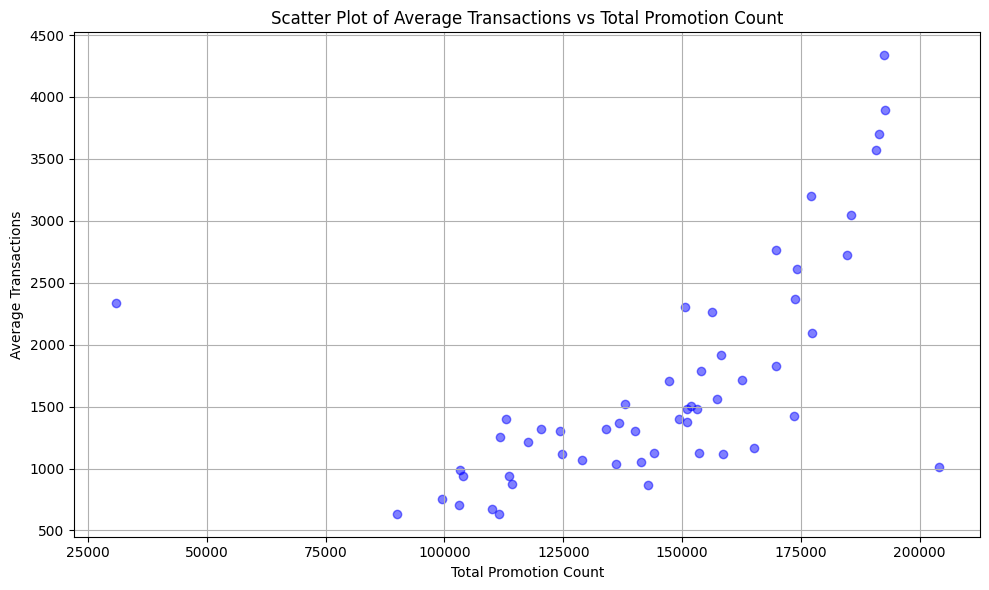

In [21]:
# Create scatter plot
plt.figure(figsize=(10, 6))
plt.scatter(sorted_df['onpromotion_sum'], sorted_df['average_transactions'], color='blue', alpha=0.5)

# Add labels and title
plt.xlabel('Total Promotion Count')
plt.ylabel('Average Transactions')
plt.title('Scatter Plot of Average Transactions vs Total Promotion Count')

# Show plot
plt.grid(True)
plt.tight_layout()
plt.show()

### We'll employ the Pearson correlation test to assess the connection between the two numerical variables. This test evaluates the linear relationship between continuous variables, yielding a coefficient between -1 and +1. For the hypotheses: H0 (>0.05): There's no impact of promotion on average transaction. H1 (<0.05): Promotion does impact average transcations.

In [22]:
correlation, p_value = pearsonr(sorted_df['onpromotion_sum'], sorted_df['average_transactions'])

print("Pearson correlation coefficient:", correlation)
print("p-value:", p_value)

Pearson correlation coefficient: 0.608581869828778
p-value: 1.0494271288749196e-06


# Can removing outliers improve correlation coefficient?

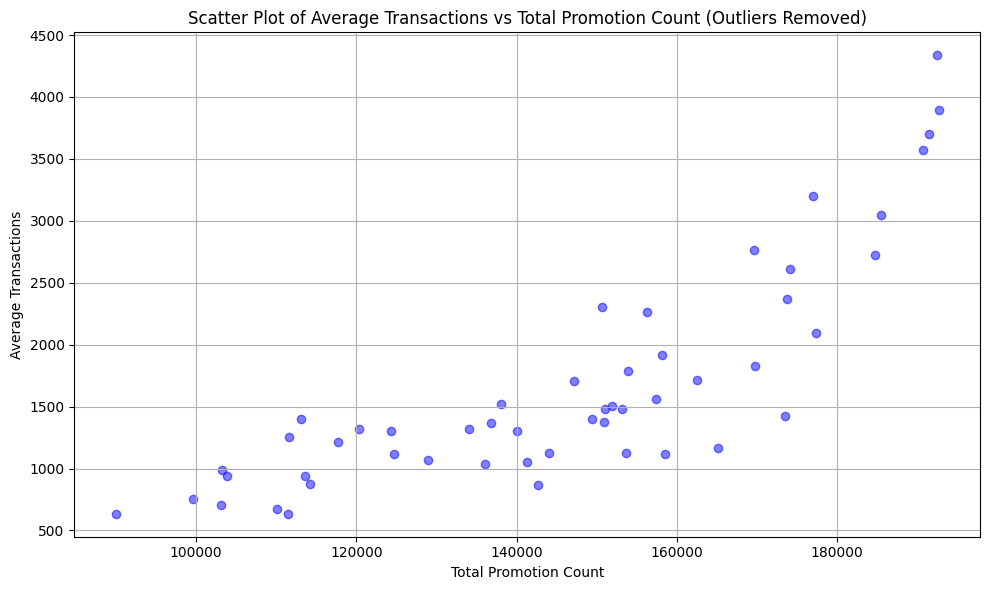

In [23]:
# Sort the DataFrame by 'onpromotion_sum'
sorted_df = sorted_df.sort_values(by='onpromotion_sum')

# Remove the lowest and highest 'onpromotion_sum' values
filtered_df = sorted_df.iloc[1:-1]

# Create scatter plot with filtered data
plt.figure(figsize=(10, 6))
plt.scatter(filtered_df['onpromotion_sum'], filtered_df['average_transactions'], color='blue', alpha=0.5)

# Add labels and title
plt.xlabel('Total Promotion Count')
plt.ylabel('Average Transactions')
plt.title('Scatter Plot of Average Transactions vs Total Promotion Count (Outliers Removed)')

# Show plot
plt.grid(True)
plt.tight_layout()
plt.show()

In [24]:
correlation, p_value = pearsonr(filtered_df['onpromotion_sum'], filtered_df['average_transactions'])

print("Pearson correlation coefficient:", correlation)
print("p-value:", p_value)

Pearson correlation coefficient: 0.8250630095130053
p-value: 5.419365867355228e-14


### Given a Pearson correlation coefficient of 0.825 and a very samll p-value, we reject the null hypothesis (H0) and affirm that there's a significant correlation between promotion and average transcations. Thus, the promotion does indeed impact store transactions.

# Which product family is on promotion most?

In [25]:
df_train.head()

,id,date,store_nbr,family,sales,onpromotion
0,0,2013-01-01,1,AUTOMOTIVE,0.0,0
1,1,2013-01-01,1,BABY CARE,0.0,0
2,2,2013-01-01,1,BEAUTY,0.0,0
3,3,2013-01-01,1,BEVERAGES,0.0,0
4,4,2013-01-01,1,BOOKS,0.0,0


In [26]:
# Group by 'family' and sum 'onpromotion', then reset index to convert to DataFrame
onpromotion_sum_by_family = df_train.groupby('family')['onpromotion'].sum().reset_index()

# Rename the columns for clarity
onpromotion_sum_by_family.columns = ['family', 'onpromotion_sum']

# Sort the DataFrame by 'onpromotion_sum' in descending order
onpromotion_sum_by_family = onpromotion_sum_by_family.sort_values(by='onpromotion_sum', ascending=False)

# Print the sorted DataFrame
print(onpromotion_sum_by_family)

                        family  onpromotion_sum
12                   GROCERY I          1914801
30                     PRODUCE          1117921
3                    BEVERAGES           906958
8                        DAIRY           728707
7                     CLEANING           661157
9                         DELI           583316
5                 BREAD/BAKERY           331289
24                       MEATS           304028
25               PERSONAL CARE           246928
28                     POULTRY           226421
18                   HOME CARE           197230
10                        EGGS           194922
11                FROZEN FOODS           125634
15          HOME AND KITCHEN I            46921
22            LIQUOR,WINE,BEER            46700
32                     SEAFOOD            39052
29              PREPARED FOODS            37524
16         HOME AND KITCHEN II            32814
31  SCHOOL AND OFFICE SUPPLIES            14565
2                       BEAUTY          

# Which month the promotions are most high

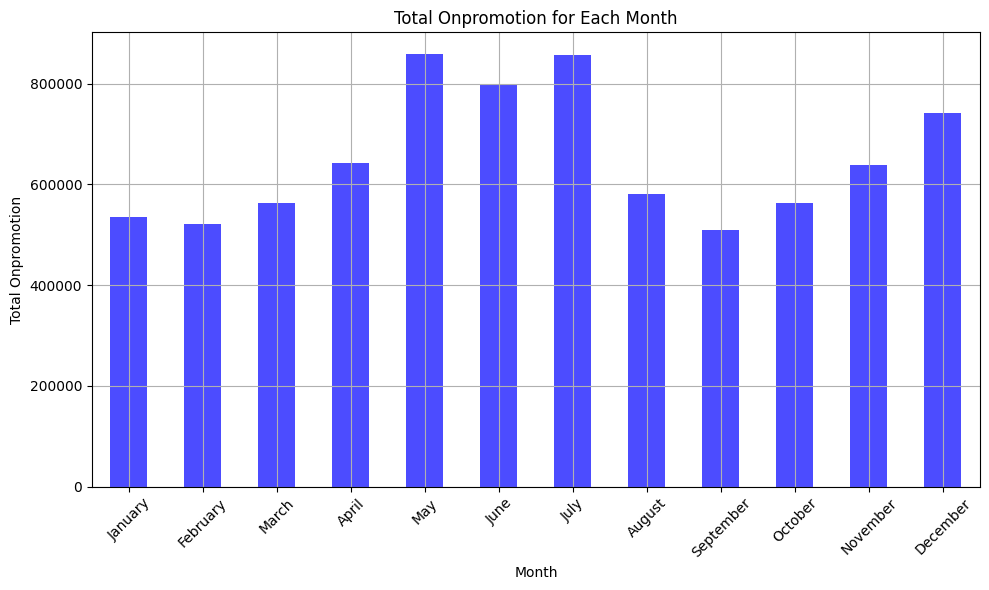

In [27]:
import calendar

# Convert 'date' column to datetime datatype for the df_train DataFrame
df_train['date'] = pd.to_datetime(df_train['date'])

# Extract month from the 'date' column and sum 'onpromotion' for each month
monthly_onpromotion_sum = df_train.groupby(df_train['date'].dt.month)['onpromotion'].sum()

# Plot the bar chart
plt.figure(figsize=(10, 6))
monthly_onpromotion_sum.plot(kind='bar', color='blue', alpha=0.7)

# Add labels and title
plt.title('Total Onpromotion for Each Month')
plt.xlabel('Month')
plt.ylabel('Total Onpromotion')
plt.xticks(range(12), [calendar.month_name[i] for i in range(1, 13)], rotation=45)  # Use month names for x-axis labels

# Show plot
plt.grid(True)
plt.tight_layout()
plt.show()

# Part 2. Sales

In [37]:
df_train.head()

,id,date,store_nbr,family,sales,onpromotion
0,0,2013-01-01,1,AUTOMOTIVE,0.0,0
1,1,2013-01-01,1,BABY CARE,0.0,0
2,2,2013-01-01,1,BEAUTY,0.0,0
3,3,2013-01-01,1,BEVERAGES,0.0,0
4,4,2013-01-01,1,BOOKS,0.0,0


# Remove stores with zero sales of a particular family of products

### Upon initial inspection of our training dataset, it's evident that numerous entries contain zeros. This observation suggests that certain stores may not carry specific products due to their unsuitability for those items. Consequently, we will eliminate these entries, as they should not contribute to sales forecasts.

In [41]:
# Grouping train DataFrame by specified columns and summing sales
df_zeros = df_train.groupby(['id', 'store_nbr', 'family']).sales.sum().reset_index()

# Filtering out rows where sales are zero
df_zeros = df_zeros[df_zeros.sales == 0]

# Performing an outer merge with train DataFrame
df_join = df_train.merge(df_zeros, on=['id', 'store_nbr', 'family'], how='outer', indicator=True, suffixes=('', '_zeros'))

# Filtering out rows exclusive to train DataFrame
df_train1 = df_join[df_join['_merge'] != 'both']

# Dropping unnecessary columns and resetting index
df_train1 = df_train1.drop(['id', '_merge', 'onpromotion', 'sales_zeros'], axis=1).reset_index(drop=True)
df_train1


,date,store_nbr,family,sales
0,2013-01-01,25,BEAUTY,2.000
1,2013-01-01,25,BEVERAGES,810.000
2,2013-01-01,25,BREAD/BAKERY,180.589
3,2013-01-01,25,CLEANING,186.000
4,2013-01-01,25,DAIRY,143.000
...,...,...,...,...
2061753,2017-08-15,9,POULTRY,438.133
2061754,2017-08-15,9,PREPARED FOODS,154.553
2061755,2017-08-15,9,PRODUCE,2419.729
2061756,2017-08-15,9,SCHOOL AND OFFICE SUPPLIES,121.000
